# Instrumental Variables
This notebook explores regressing effective radii on ship presence and then cloud properties 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import sys
import datetime
import iris
from pyhdf.SD import SD, SDC
import time
import xarray as xr
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from time_collapse_tools import (load_emis, load_modis,
                                coarsened_emis, time_collapse_emis, 
                                 select_lonlats, select_data, 
                                 re_diff_emis, load_modis_outcome,
                                drop_num)

from cis import read_data, read_data_list, get_variables

In [2]:
def conditional_p(X, Y):
    Xhist, bounds=np.histogram(X, bins=20)
    jointhist, xbounds, ybounds=np.histogram2d(X,Y, bins=20)
    jointhist=jointhist.T
    cond_prob=jointhist/Xhist
    x, y = np.meshgrid(xbounds, ybounds)
    plt.pcolormesh(x, y, cond_prob)
    plt.colorbar()
    return cond_prob, xbounds, ybounds

def filter_nan(var_list):
    for i in range(len(var_list)):
        var_list[i]=var_list[i][np.logical_not(np.isnan(var_list[-1]))]
    return var_list

def filter_cond(var_list, condmask):
    for i in range(len(var_list)):
        var_list[i]=var_list[i][condmask]
    return var_list

def expectation_from_hist(ybounds,hist):
    expect=np.empty(20)
    for j in range(20):
        av=0
        for i in range(20):
            av+=hist.T[j, i]*(i*0.05+0.025)
        expect[j]=av* (ybounds[-1]-ybounds[0])+ybounds[0]
    return expect

## Part 1: get data

In [15]:
modis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis_aqua/'
emis_dir='/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/colloc_emission_modis/downsampled_emis/'

months=['01','02','03','04','05','06','07','08','09','10','11','12']
#'01','02', '03','04','05','06','07','08','09','10','11','12'
datlist=[[],[],[],[],[]]
for month in months:
    
    da=load_emis(emis_dir, month=month)
    datlist[0].append(da)
    
    re, ctt=load_modis(modis_dir, uncert_thresh=10, month=month)
    datlist[1].append(re)
    datlist[2].append(ctt)
    
    cot=load_modis_outcome(modis_dir+'targets/', month, target='Cloud_Optical_Thickness',uncert_thresh=8)
    datlist[3].append(cot)
    ta=load_modis_outcome(modis_dir+'targets/', month, target='Cloud_Optical_Thickness',uncert_thresh=8)
    datlist[4].append(ta)

0.12199776780100965
0.7194740386844383
0.7350088999904438
0.0
0.49210888851395995
0.0
0.49210888851395995
0.10190247379302106
0.7073434212737695
0.7235631974437945
0.0
0.5001098496123372
0.0
0.5001098496123372
0.13413952203873564
0.7523242166156626
0.762109405184353
0.0
0.4901290807244908
0.0
0.4901290807244908
0.14488148053653857
0.7043590216061194
0.7153647715836771
0.0
0.45559996787194135
0.0
0.45559996787194135
0.1193901826224086
0.65849824492097
0.669734225664253
0.0
0.4176429679559193
0.0
0.4176429679559193
0.11321738883927938
0.5406108110917398
0.5544915498481005
0.0
0.35536703944664144
0.0
0.35536703944664144
0.09168110371769496
0.5184449044182634
0.5392571194208171
0.0
0.3826483792781337
0.0
0.3826483792781337
0.0855610743269225
0.503495755301244
0.5137125694018648
0.0
0.3384991228034078
0.0
0.3384991228034078
0.08721539500975653
0.5556212290872324
0.5670077910542255
0.0
0.35882742035312515
0.0
0.35882742035312515
0.18592589849209976
0.647112749824995
0.6555948316500395
0.0
0.

In [4]:
comb_da=xr.concat(datlist[0], dim='time')
comb_re=xr.concat(datlist[1], dim='time')
comb_ctt=xr.concat(datlist[2], dim='time')
comb_cot=xr.concat(datlist[3], dim='time')
comb_ta=xr.concat(datlist[4], dim='time')

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


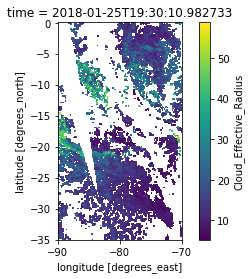

In [5]:
comb_re.isel(time=24).plot()
plt.axes().set_aspect('equal')

In [6]:
#adj_re=comb_re-comb_re.isel(time=slice(1,len(comb_re.time)-1)).mean('time')
emis_h=20
end_h=24
lats=slice(-35,-17)
lons=slice(-77.5,-72.5)
re_sel, emis_sel=select_data(comb_re,
                             comb_da, emis_h=emis_h,end_h=end_h,lats=lats, lons=lons, coarsening=1)
ta_sel, emis_sel=select_data(comb_ta,
                             comb_da, emis_h=emis_h,end_h=end_h,lats=lats, lons=lons, coarsening=1)
ctt_sel, emis_sel=select_data(comb_ctt,
                             comb_da, emis_h=emis_h,end_h=end_h,lats=lats, lons=lons, coarsening=1)
cot_sel, emis_sel=select_data(comb_cot,
                             comb_da, emis_h=emis_h,end_h=end_h,lats=lats, lons=lons, coarsening=1)


In [7]:
COT=cot_sel.values
CTT=ctt_sel.values
X=re_sel.values

In [8]:
N_d=drop_num(X, COT, CTT)
N_d_mean=np.nanmean(N_d, axis=-1)
N_d_mean=np.tile(N_d_mean, (np.shape(N_d)[-1],1,1)).transpose(1,2,0)
N_d-=N_d_mean

In [9]:
X_mean=np.nanmean(X, axis=-1)
X_mean=np.tile(X_mean, (np.shape(X)[-1],1,1)).transpose(1,2,0)
X-=X_mean

In [10]:
#look at 9/10

In [11]:
Z=emis_sel.values.flatten()
Y=ta_sel.values.flatten()

In [12]:
X=X.flatten()
X_mean=X_mean.flatten()
COT=COT.flatten()
CTT=CTT.flatten()
N_d=N_d.flatten()
N_d_mean=N_d_mean.flatten()

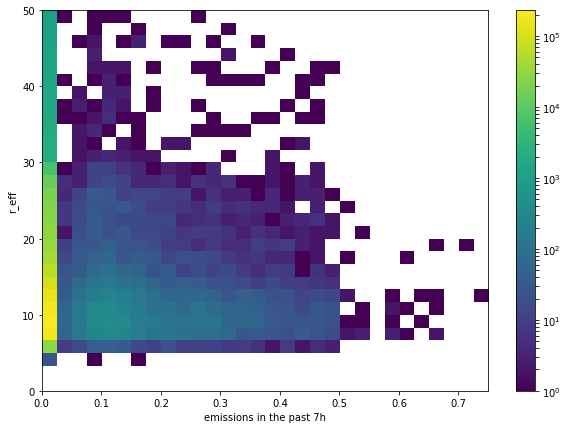

In [13]:
plt.figure(figsize=(10,7))
#range=[[0.0, 2], [-30, 30]]
plt.hist2d(Z,X+X_mean, bins=30,range=[[0.0, 0.75], [0, 50]],norm=LogNorm())
plt.ylabel('r_eff')
plt.xlabel('emissions in the past 7h')
plt.colorbar()

## Part 2: Try IV for r_eff-Nd-LWP relationship

In [56]:
#here, try to regress r_eff on ship 
#and regress LWP on Nd calculated from r_eff predicted by ship 

In [57]:
[z,y,x_mean,x]=filter_nan([Z,Y,N_d_mean, N_d])
[z,x,x_mean,y]=filter_nan([z,x,x_mean,y])

In [58]:
z_t=np.where(z>0.0, 1, 0)
n=len(x)

regr_zx = LinearRegression(
   fit_intercept = True).fit(z_t.reshape(-1, 1),x)

print(regr_zx.coef_)

RSS_2=((regr_zx.predict(z_t.reshape(-1, 1)) - x) ** 2).sum()
RSS_1=((x-np.mean(x))**2).sum()
F=((RSS_1-RSS_2)/1)/(RSS_2/(n-2))

F

[4.48117409]


52.48178360825636

(array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99413146e-01,
         9.73439575e-01, 8.79912664e-01, 8.15817985e-01, 9.12139738e-01,
         7.91203566e-01, 4.20824904e-01, 2.66540604e-01, 2.06612404e-01,
         1.07114986e-01, 5.90755697e-02, 6.79876726e-02, 6.32716672e-02,
         5.66179080e-02, 5.85260792e-03, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.86854460e-04,
         2.58964143e-02, 6.47743814e-02, 7.42145179e-02, 3.66812227e-02,
         1.72659733e-01, 4.32737694e-01, 4.34094506e-01, 4.43528858e-01,
         4.65350398e-01, 4.48634336e-01, 4.29540007e-01, 4.70850992e-01,
         4.63951425e-01, 3.04335612e-01, 2.58939581e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         6.64010624e-04, 3.63901019e-02, 4.71289274e-02, 1.78165939e-02,
         1.67607727e-02, 1.07636548e-01, 1.93369371e-01, 2.26456343e-01,
         2.69181030e-01, 3.02834970e-01, 2.840862

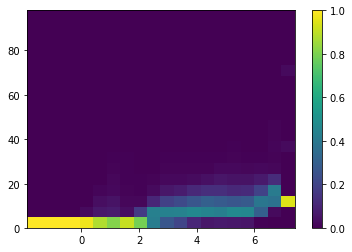

In [59]:
conditional_p(np.log(x+x_mean),y)

In [60]:
regr_xy = LinearRegression(
   fit_intercept = True).fit(np.log(x+x_mean).reshape(-1, 1),y)
print(regr_xy.coef_, regr_xy.intercept_)

[1.48544386] 3.6889842365189667


In [ ]:
plt.figure(figsize=(10,7))
#range=[[0.0, 2], [-30, 30]]
plt.hist2d(np.log(x+x_mean),y, bins=30,norm=LogNorm())
plt.plot(np.log(x+x_mean), regr_xy.predict(np.log(x+x_mean).reshape(-1, 1)))
plt.colorbar()

In [62]:
regr_xy_IV = LinearRegression(
   fit_intercept = True).fit(np.log(regr_zx.predict(z_t.reshape(-1, 1))+x_mean).reshape(-1, 1),y)
regr_xy_IV.coef_

array([2.34123705])

array([1.3615927])

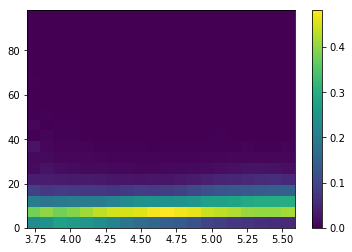

In [63]:
cond_prob, xbounds, ybounds=conditional_p(np.log(regr_zx.predict(z_t.reshape(-1, 1))+x_mean),y)
#plt.scatter(xbounds[:-1]+(xbounds[1]-xbounds[0])/2, expectation_from_hist(ybounds,cond_prob))
regr_xy_IV_cond = LinearRegression(
   fit_intercept = True).fit((xbounds[:-1]+(xbounds[1]-xbounds[0])/2).reshape(-1,1), expectation_from_hist(ybounds,cond_prob))
regr_xy_IV_cond.coef_

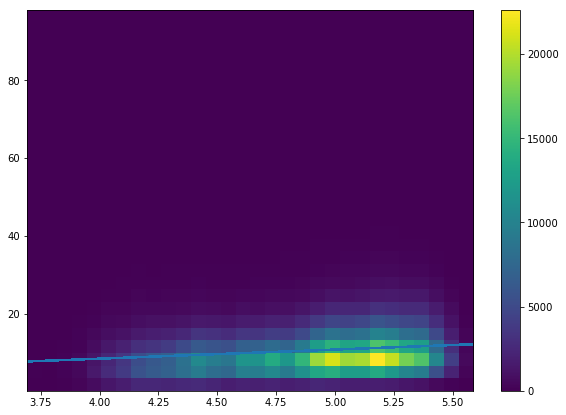

In [64]:
plt.figure(figsize=(10,7))
#range=[[0.0, 2], [-30, 30]]
plt.hist2d(np.log(regr_zx.predict(z_t.reshape(-1, 1))+x_mean),y, bins=30,)
plt.plot(x+x_mean, regr_xy_IV.predict((x+x_mean).reshape(-1, 1)))
plt.colorbar()

(array([  1348.,  17294.,  56825.,  89631.,  98964., 118098., 181113.,
        208029., 191050.,  51860.]),
 array([3.6917952 , 3.88140047, 4.07100575, 4.26061102, 4.45021629,
        4.63982157, 4.82942684, 5.01903211, 5.20863739, 5.39824266,
        5.58784793]),
 <a list of 10 Patch objects>)

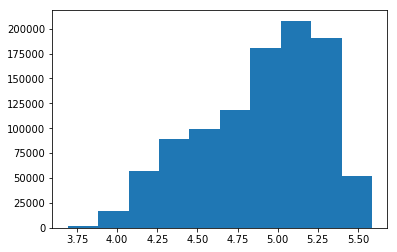

In [65]:
plt.hist(np.log(regr_zx.predict(z_t.reshape(-1, 1))+x_mean))

In [66]:
# oh no: the IV one comes with a larger slope. That is the opposite of what I expected
# it could be because the predicted Nd values are all on the downward sloping branch

In [67]:
regr_xy = LinearRegression(
   fit_intercept = True).fit(np.log(x+x_mean)[(np.log(x+x_mean)>4)&(np.log(x+x_mean)<5.75)].reshape(-1, 1),y[(np.log(x+x_mean)>4)&(np.log(x+x_mean)<5.75)])
print(regr_xy.coef_)

[0.24009979]


In [16]:
plt.figure(figsize=(10,7))
#range=[[0.0, 2], [-30, 30]]
plt.hist2d(np.log(x+x_mean)[(np.log(x+x_mean)>4)&(np.log(x+x_mean)<5.75)],y[(np.log(x+x_mean)>4)&(np.log(x+x_mean)<5.75)], bins=30,)
plt.plot(np.log(x+x_mean)[np.log(x+x_mean)>4], regr_xy.predict(np.log(x+x_mean).reshape(-1, 1))[np.log(x+x_mean)>4])
plt.colorbar()

NameError: name 'x' is not defined

<Figure size 720x504 with 0 Axes>

In [69]:
mask=[(np.log(x+x_mean)>3.69)&(np.log(x+x_mean)<5.58)]

<ipython-input-70-9022f0f3d347>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cond_prob, xbounds, ybounds=conditional_p(np.log(x+x_mean)[mask],y[mask])


array([0.72191898])

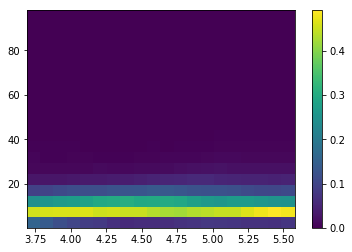

In [70]:
cond_prob, xbounds, ybounds=conditional_p(np.log(x+x_mean)[mask],y[mask])
regr_xy_cond = LinearRegression(
   fit_intercept = True).fit((xbounds[:-1]+(xbounds[1]-xbounds[0])/2).reshape(-1,1), expectation_from_hist(ybounds,cond_prob))
regr_xy_cond.coef_